In [4]:
from pathlib import Path

family = Path('../data/2021_family_composition_amsterdam.xlsx')
prices = Path('../data/woz_prices_2021_amsterdam.xlsx')

assert prices.exists() and family.exists()

In [5]:
import pandas as pd 

dfp = pd.read_excel(prices, header=None)
dff = pd.read_excel(family, header=None)
transformed_flag = False
# dfp.columns


In [6]:
import numpy as np

if not transformed_flag:
    new_columns_p = dfp.iloc[2].values
    new_columns_f = dff.iloc[2].values

    dfp.drop(dfp.index[0:4], inplace=True)
    dff.drop(dff.index[0:4], inplace=True)
     
    dfp.drop(dfp.index[-3:], inplace=True)
    dff.drop(dff.index[-3:], inplace=True)

    dfp.columns = new_columns_p
    dff.columns = new_columns_f

    dff = dff.map(lambda x: 0 if x=='-' else x)
    dff = dff.convert_dtypes()

    dfp = dfp.map(lambda x: np.nan if x=='.' else x)
    dfp.dropna(inplace=True)
    # dfp = dfp.map(lambda x: int(x) if isinstance(x, int) or isinstance(x, float) else x)
    dfp.convert_dtypes()

    transformed_flag = True

In [7]:
print(f'Unique areas names in prices df = {dfp["area"].nunique()}')
print(f'Unique areas names in family df = {dff["area"].nunique()}')

Unique areas names in prices df = 397
Unique areas names in family df = 481


In [8]:
dff

,area,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total
4,A00a Kop Zeedijk,543,37,149,14,12,22,12,789
5,A00b Oude Kerk e.o.,331,20,104,8,3,20,12,498
6,A00c Burgwallen Oost,676,55,231,30,23,43,26,1084
7,A00d Nes e.o.,130,16,59,5,8,11,5,234
8,A00e BG-terrein e.o.,348,24,73,19,9,14,6,493
...,...,...,...,...,...,...,...,...,...
480,T97b Gein Zuidwest,421,41,70,72,51,186,10,851
481,T97c Gein Noordoost,380,362,91,325,107,125,14,1404
482,T97d Gein Zuidoost,718,242,97,220,104,274,17,1672
483,T98a Dorp Driemond,193,144,42,139,60,68,0,646


In [9]:
dfp.drop('woz-value per m2', axis=1, inplace=True)
merged_df = dfp.merge(dff, on='area', how='inner')

In [10]:
merged_df

,area,average woz value,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total
0,A00a Kop Zeedijk,432583.0,543,37,149,14,12,22,12,789
1,A00b Oude Kerk e.o.,475037.0,331,20,104,8,3,20,12,498
2,A00c Burgwallen Oost,469793.0,676,55,231,30,23,43,26,1084
3,A00d Nes e.o.,605863.0,130,16,59,5,8,11,5,234
4,A00e BG-terrein e.o.,556369.0,348,24,73,19,9,14,6,493
...,...,...,...,...,...,...,...,...,...,...
381,T97a Gein Noordwest,211475.0,977,71,142,88,63,300,22,1663
382,T97b Gein Zuidwest,221090.0,421,41,70,72,51,186,10,851
383,T97c Gein Noordoost,332620.0,380,362,91,325,107,125,14,1404
384,T97d Gein Zuidoost,280695.0,718,242,97,220,104,274,17,1672


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

X = merged_df.drop('average woz value', axis=1)
X = X.drop('area', axis=1)
y = merged_df['average woz value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate model
predictions_xgb = xgb_model.predict(X_test)
predictions_forest = forest_model.predict(X_test)
mape_xgb = mean_absolute_percentage_error(y_test, predictions_xgb)
mape_forest = mean_absolute_percentage_error(y_test, predictions_forest)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
mae_forest = mean_absolute_error(y_test, predictions_forest)
print(f'Mean Absolute Error: {mae_forest}')
print(f'Mean Absolute Error: {mae_xgb}')
print(f'Mean Absolute Percentage Error: {mape_forest}')
print(f'Mean Absolute Percentage Error: {mape_xgb}')

Mean Absolute Error: 115475.58327586207
Mean Absolute Error: 121745.27970096983
Mean Absolute Percentage Error: 0.31977132479083886
Mean Absolute Percentage Error: 0.3089234539429652


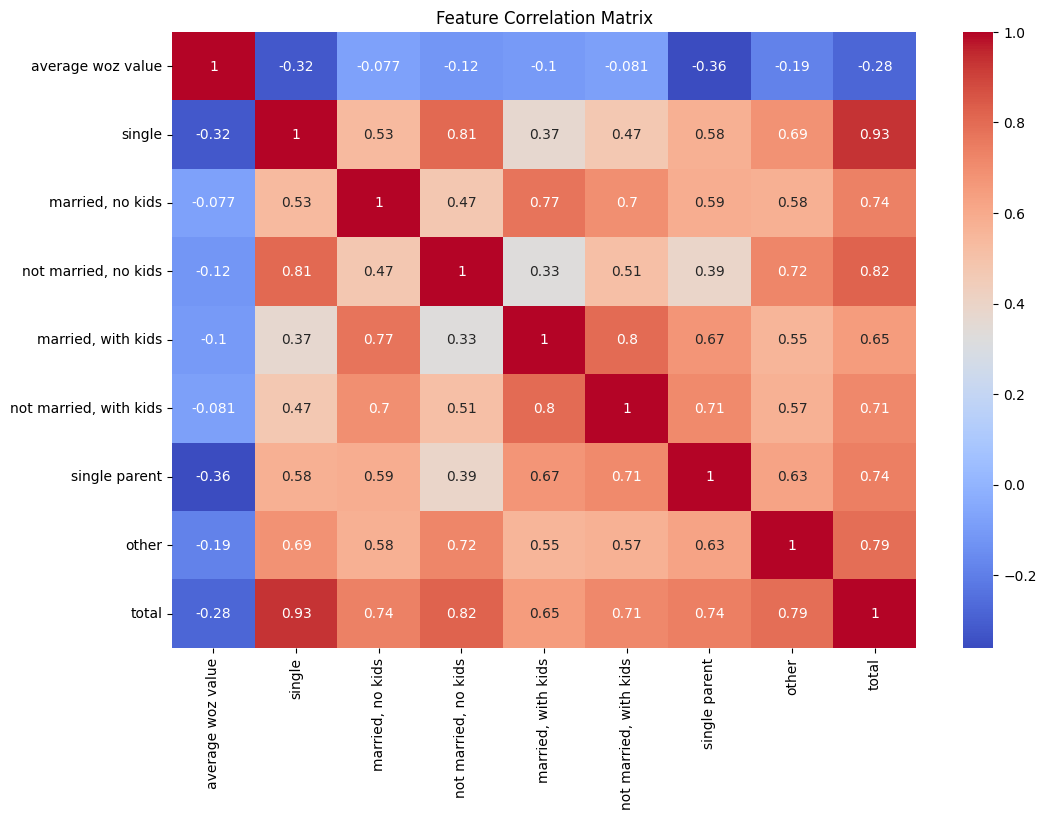

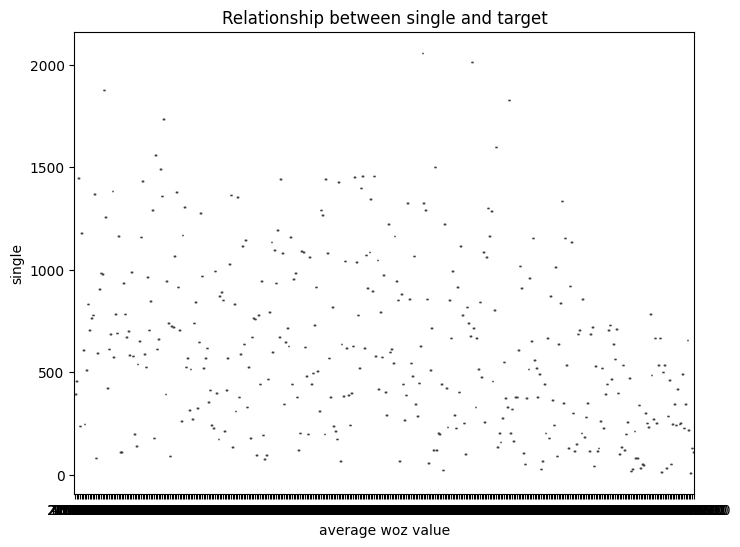

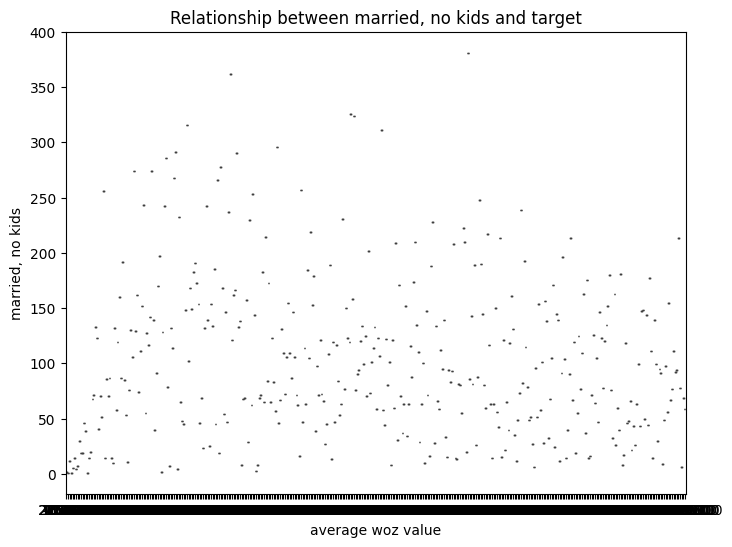

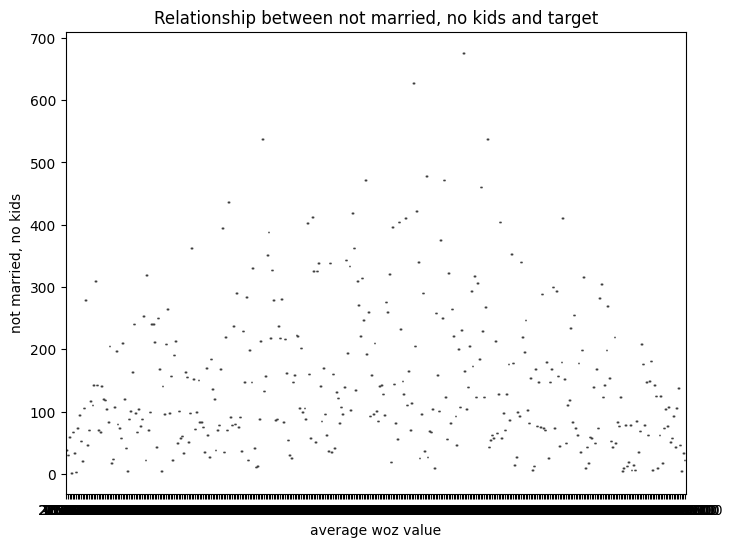

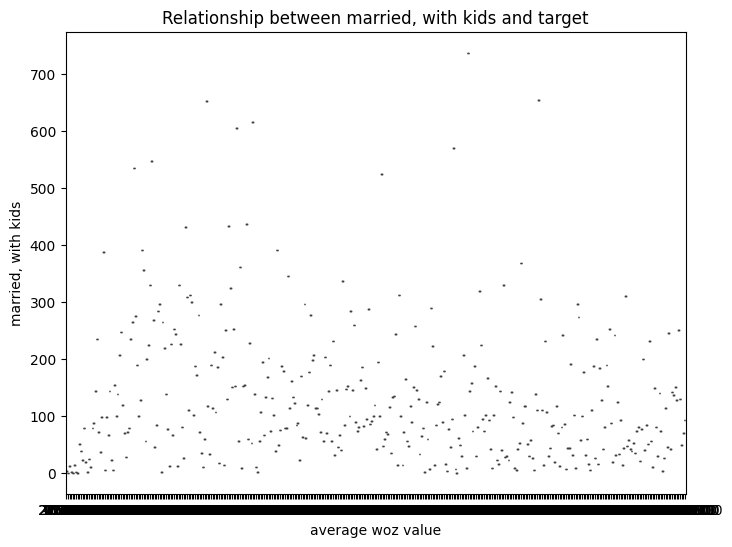

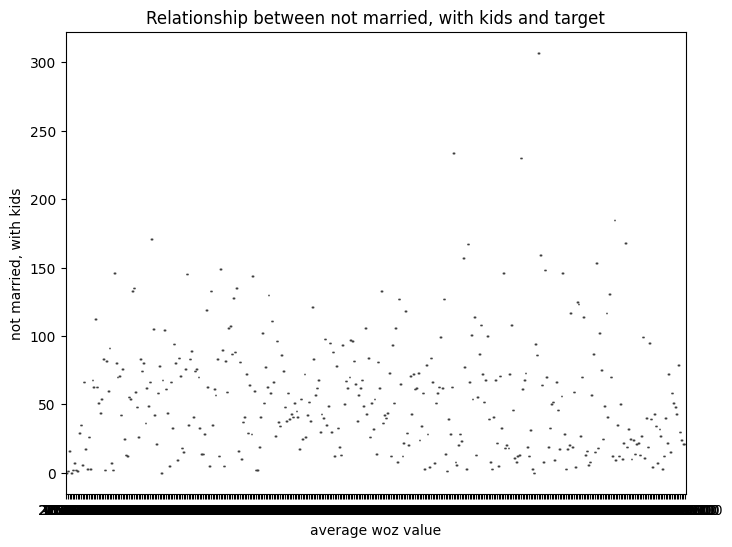

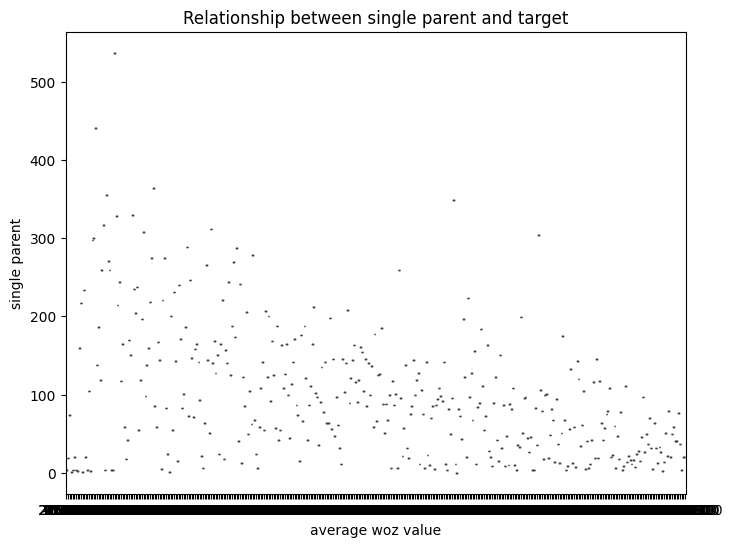

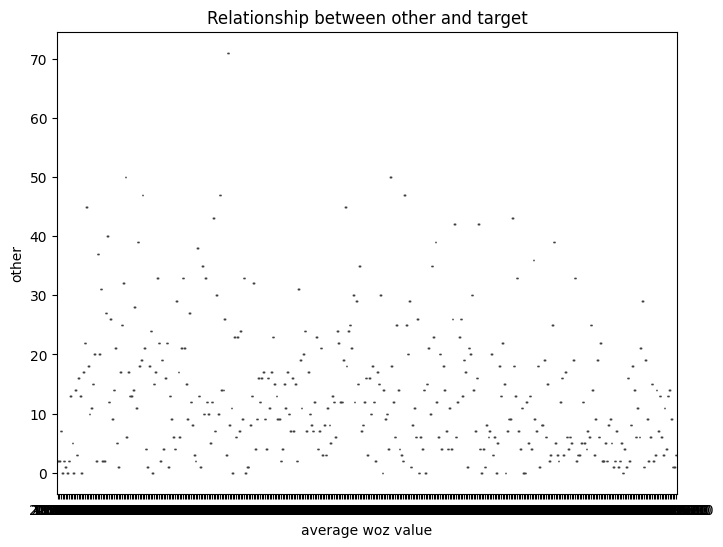

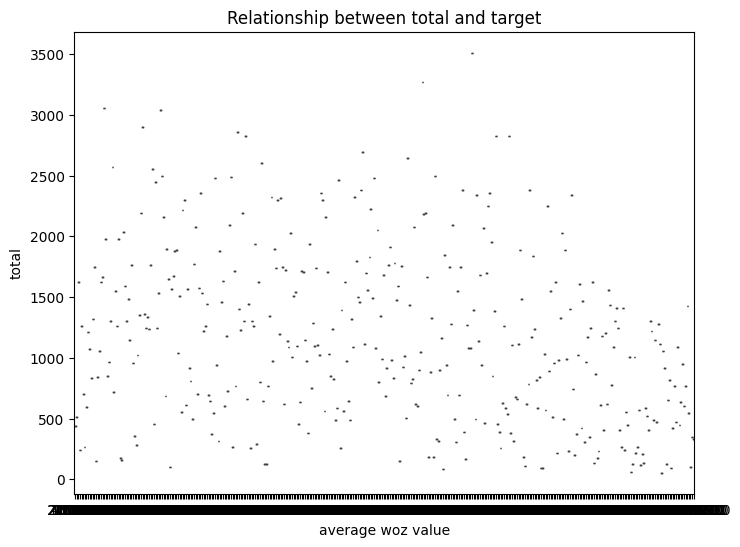

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns 

correlation_matrix = merged_df.drop('area', axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Visualize relationships between features and the target
for column in X.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y, y=X[column])
    plt.title(f'Relationship between {column} and target')
    plt.show()

In [150]:
merged_df.columns


Index(['area', 'average woz value', 'single', 'married, no kids',
       'not married, no kids', 'married, with kids', 'not married, with kids',
       'single parent', 'other', 'total'],
      dtype='object')

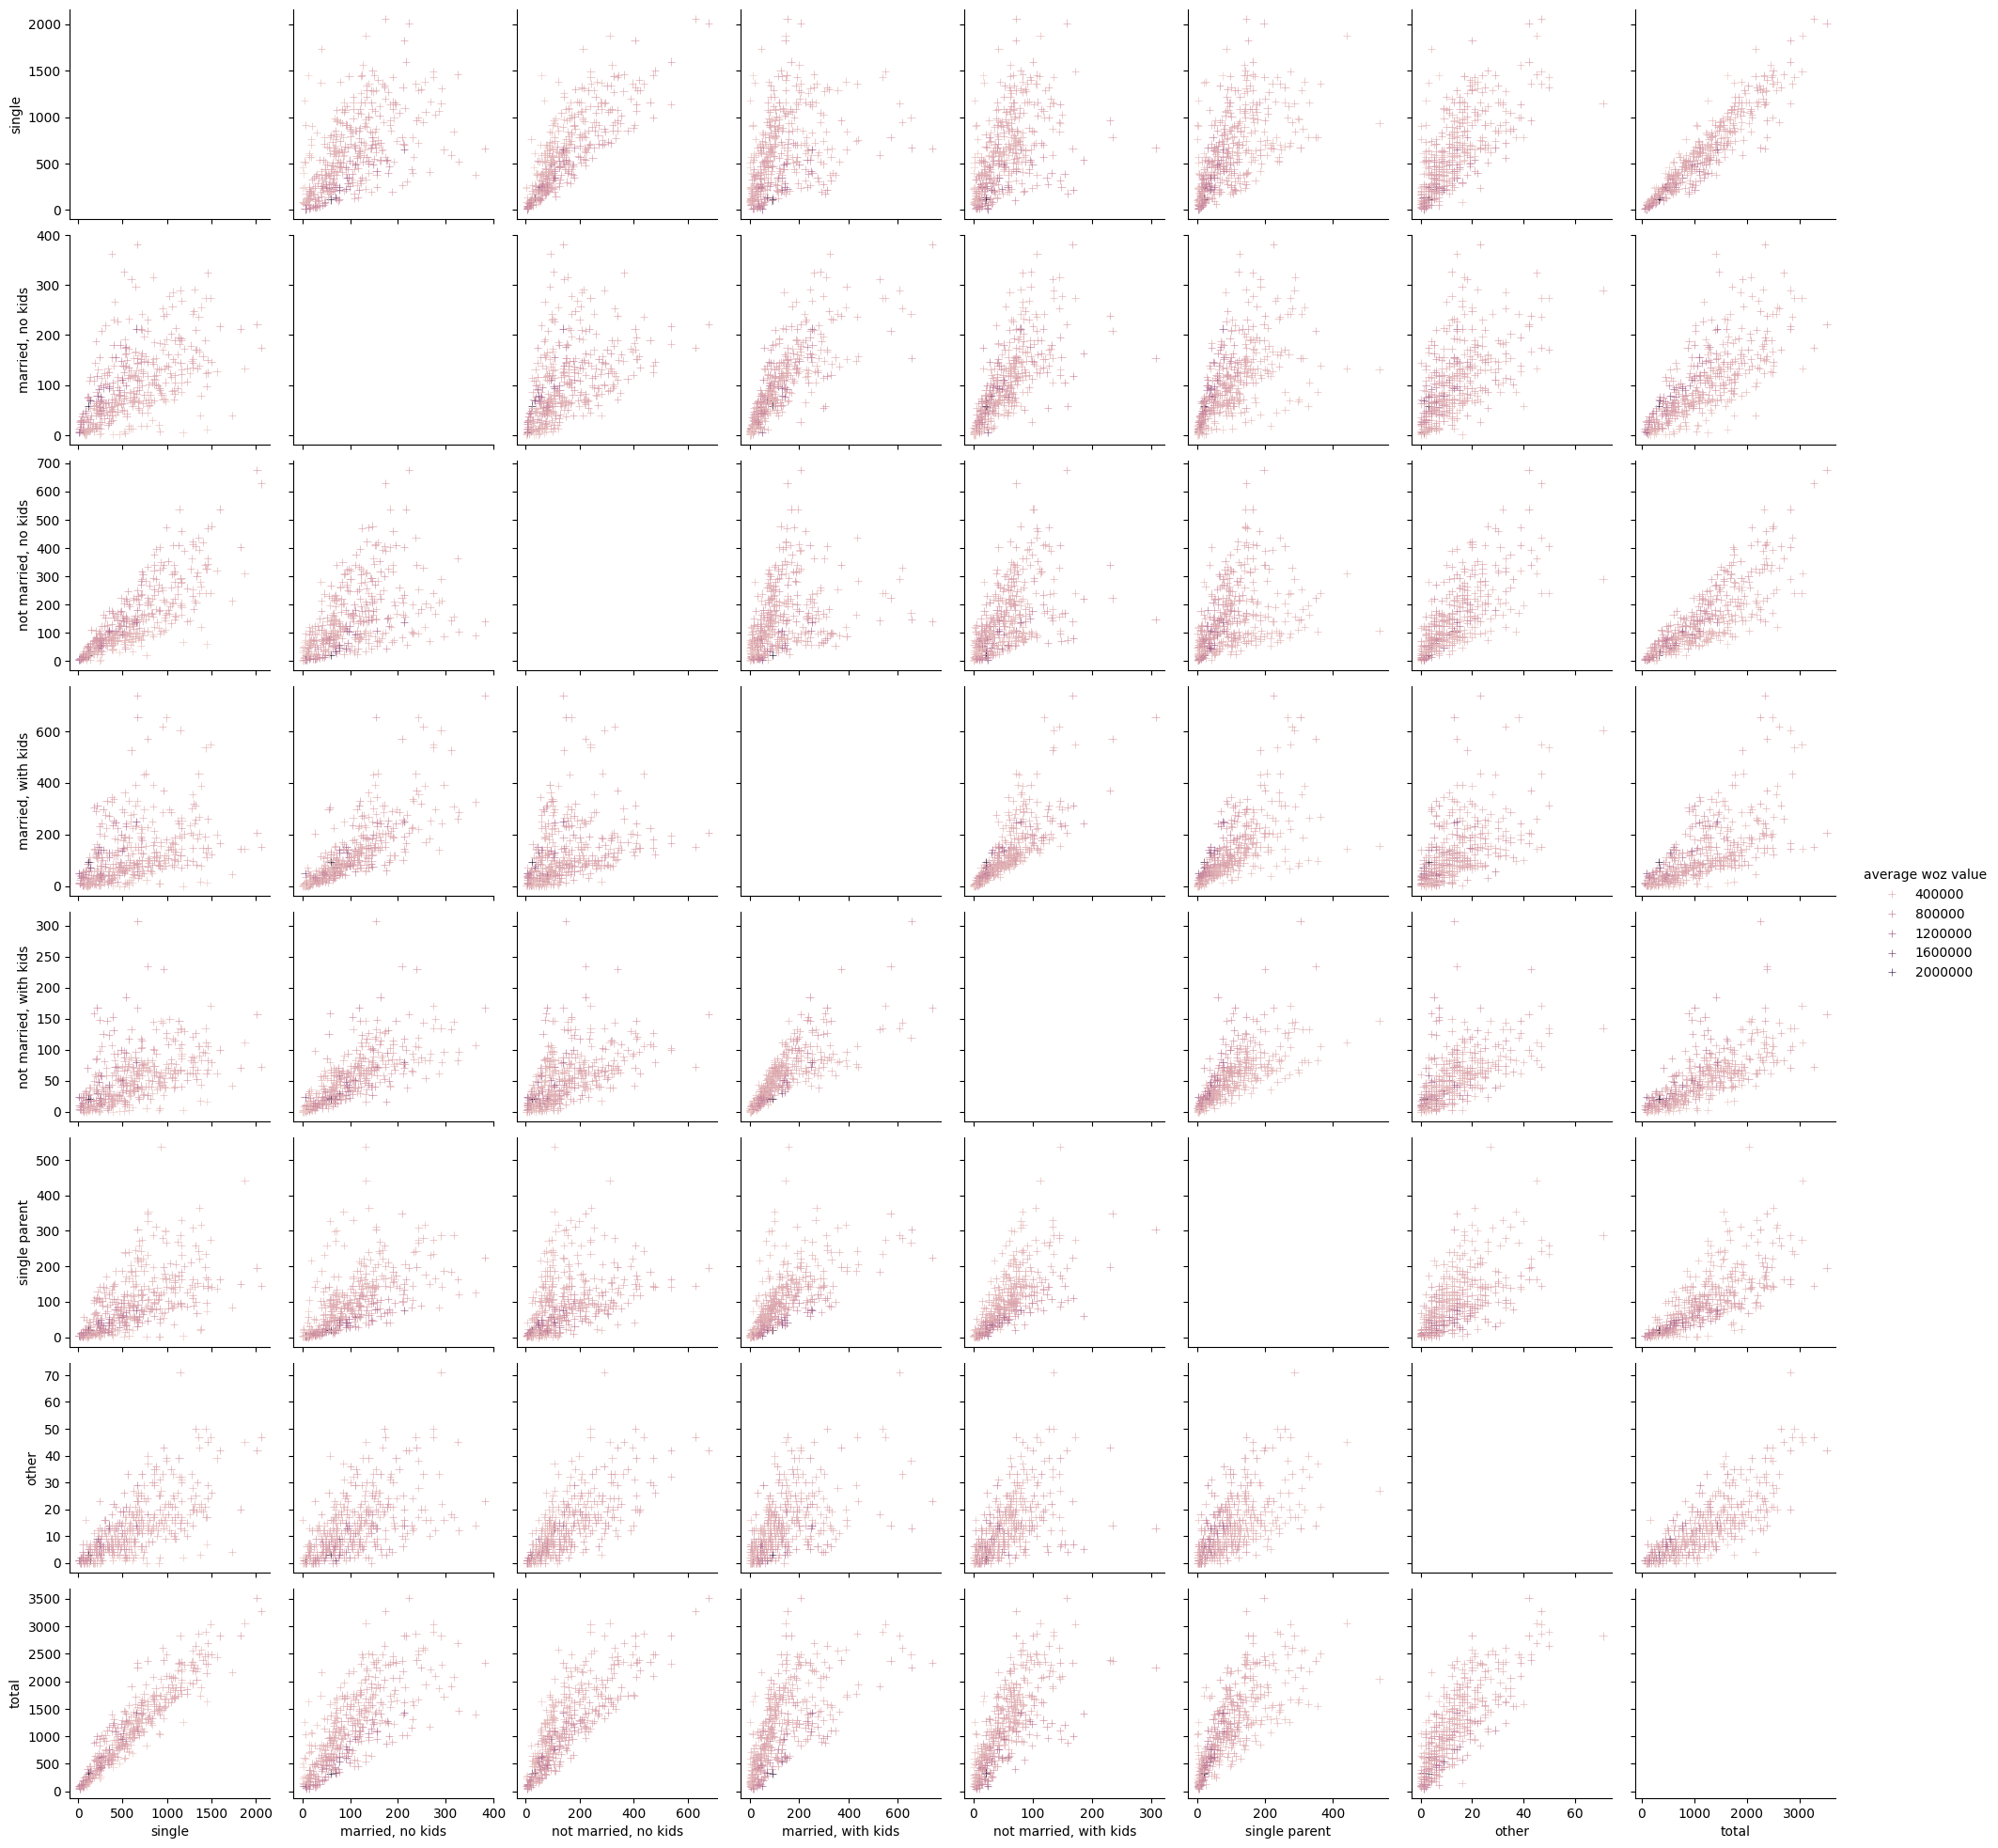

In [11]:

sns.pairplot(merged_df, hue='average woz value', diag_kind='kde', markers='+')
plt.show()

In [151]:
dfp.head()

,area,average woz value
4,A00a Kop Zeedijk,432583.000
5,A00b Oude Kerk e.o.,475037.000
6,A00c Burgwallen Oost,469793.000
7,A00d Nes e.o.,605863.000
8,A00e BG-terrein e.o.,556369.000


In [152]:
pd.set_option('display.float_format', lambda x: '%3.3f' % x)
dfp['average woz value'].describe()

count       397.000
mean     462938.428
std      235135.641
min       22371.000
25%      325180.000
50%      417322.000
75%      526534.000
max     2293760.000
Name: average woz value, dtype: float64

In [153]:
dfp.tail()

,area,average woz value
428,T97a Gein Noordwest,211475.000
429,T97b Gein Zuidwest,221090.000
430,T97c Gein Noordoost,332620.000
431,T97d Gein Zuidoost,280695.000
432,T98a Dorp Driemond,351711.000


In [15]:
dff.head()

,area,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total
4,A00a Kop Zeedijk,543,37,149,14,12,22,12,789
5,A00b Oude Kerk e.o.,331,20,104,8,3,20,12,498
6,A00c Burgwallen Oost,676,55,231,30,23,43,26,1084
7,A00d Nes e.o.,130,16,59,5,8,11,5,234
8,A00e BG-terrein e.o.,348,24,73,19,9,14,6,493


In [16]:
dff.tail()

,area,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total
480,T97b Gein Zuidwest,421,41,70,72,51,186,10,851
481,T97c Gein Noordoost,380,362,91,325,107,125,14,1404
482,T97d Gein Zuidoost,718,242,97,220,104,274,17,1672
483,T98a Dorp Driemond,193,144,42,139,60,68,0,646
484,T98b Landelijk Gebied Driemond,4,9,1,18,8,3,0,43


In [154]:
merged_df.columns

Index(['area', 'average woz value', 'single', 'married, no kids',
       'not married, no kids', 'married, with kids', 'not married, with kids',
       'single parent', 'other', 'total'],
      dtype='object')

In [167]:
from sklearn.preprocessing import MinMaxScaler


df_with_percents = merged_df.copy()
df_with_percents['single_per'] = merged_df['single'] / merged_df['total']
df_with_percents['single_par_per'] = merged_df['single parent'] / merged_df['total']
df_with_percents['mar_no_kid_per'] = merged_df['married, no kids'] / merged_df['total']
df_with_percents['mar_with_kid_per'] = merged_df['married, with kids'] / merged_df['total']
df_with_percents['no_mar_no_kid_per'] = merged_df['not married, no kids'] / merged_df['total']
df_with_percents['no_mar_with_kid_per'] = merged_df['not married, with kids'] / merged_df['total']

scaler = MinMaxScaler()
df_with_percents['total_scaled'] = scaler.fit_transform(merged_df[['total']])

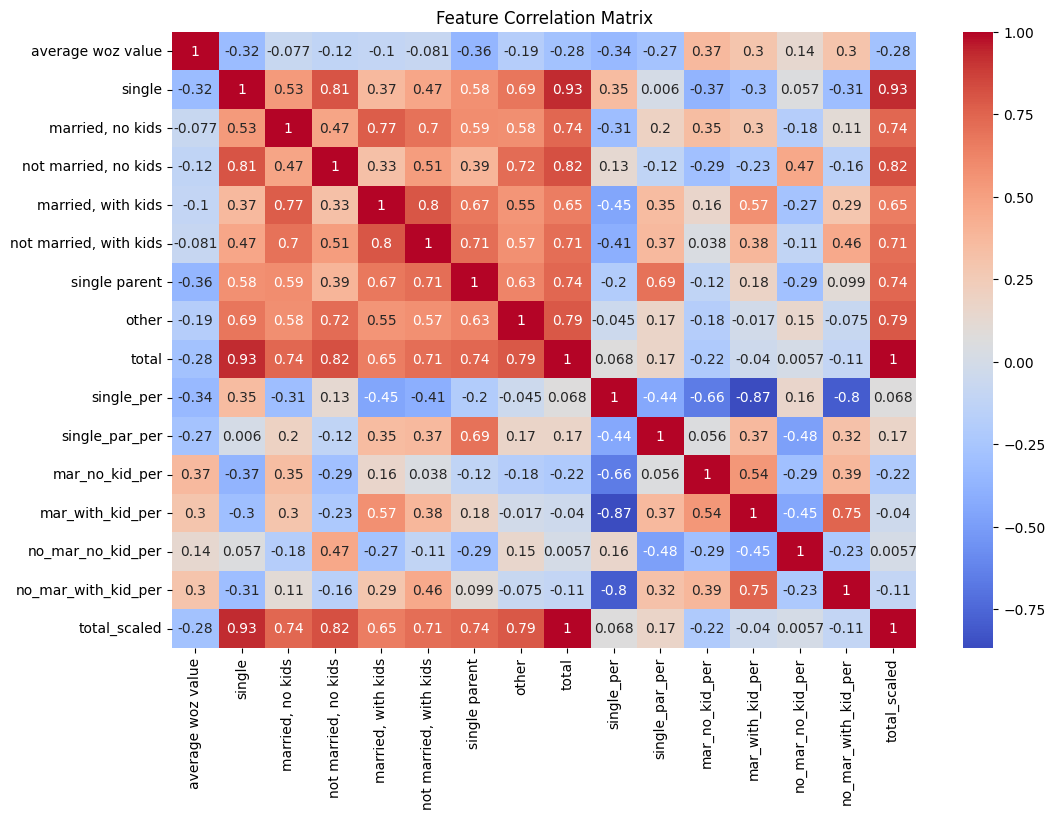

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns 

df_no_area = df_with_percents.drop('area', axis=1)
correlation_matrix = df_no_area.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# # Visualize relationships between features and the target
# for column in df_with_percents.columns:
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(x=y, y=X[column])
#     plt.title(f'Relationship between {column} and target')
#     plt.show()

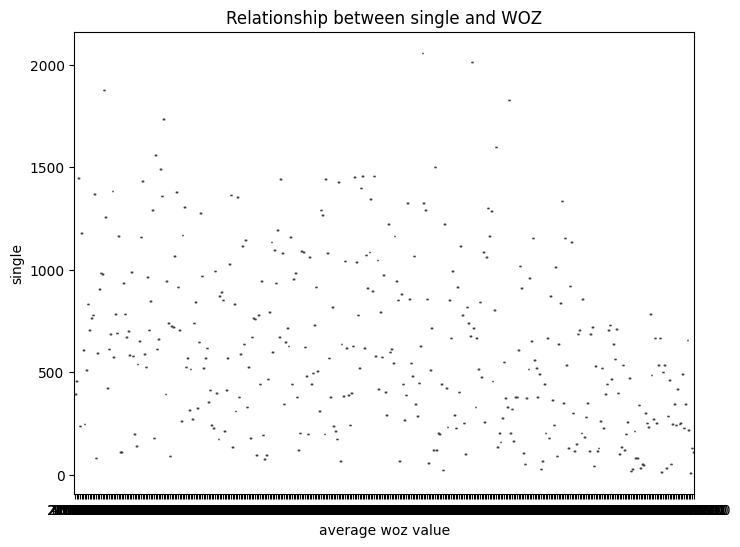

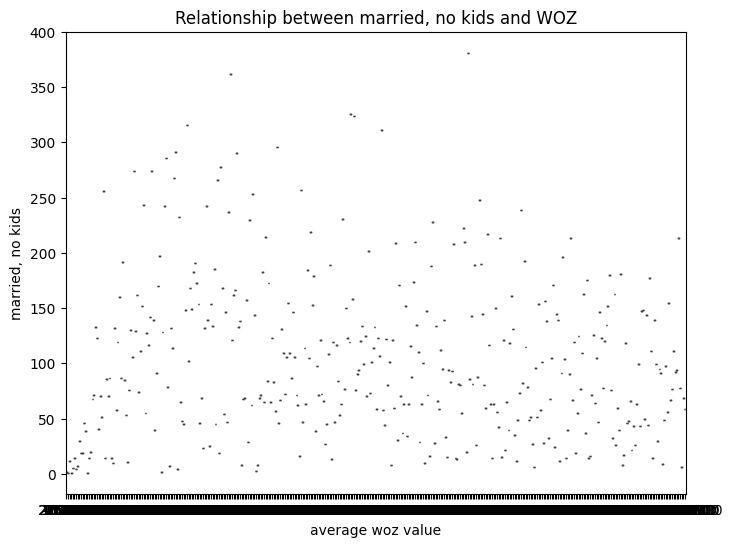

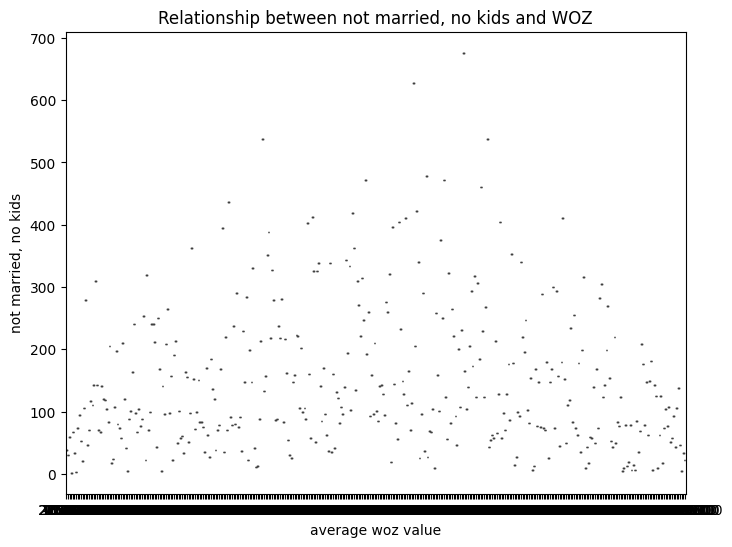

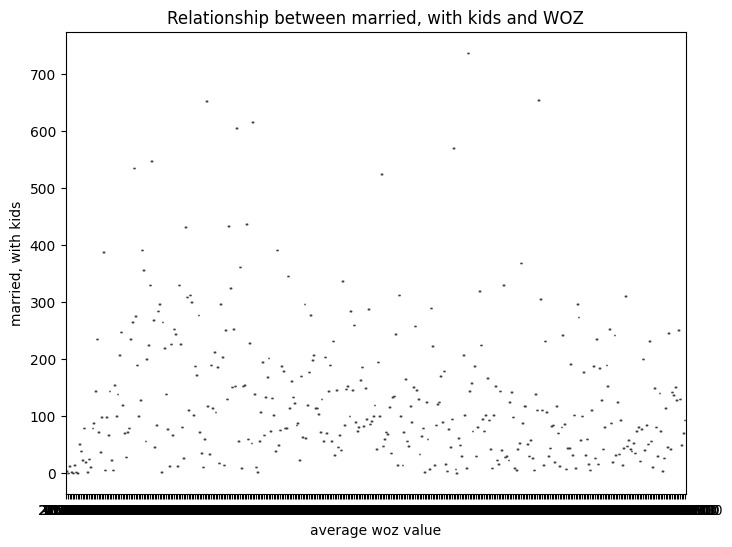

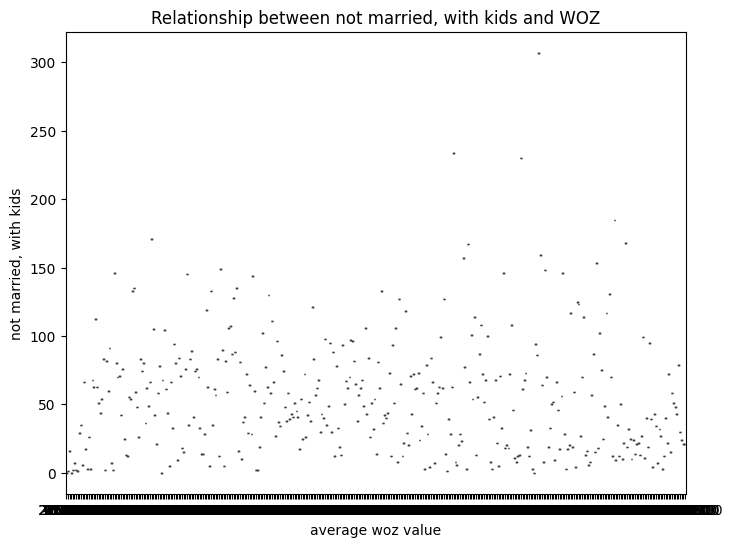

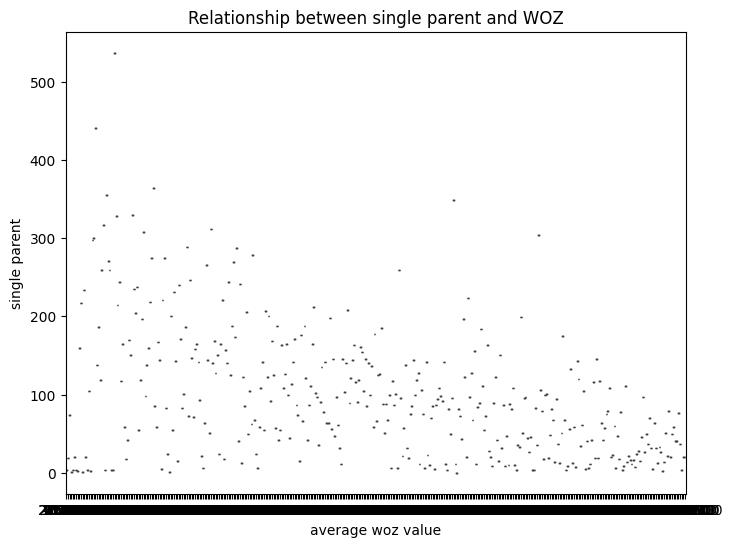

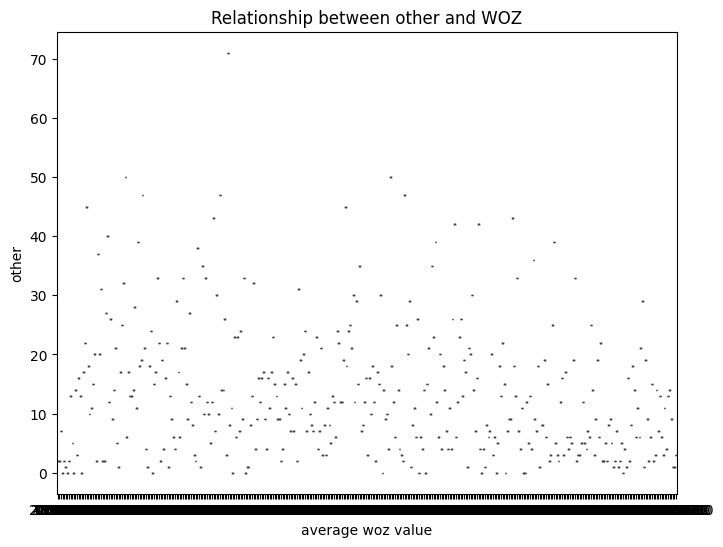

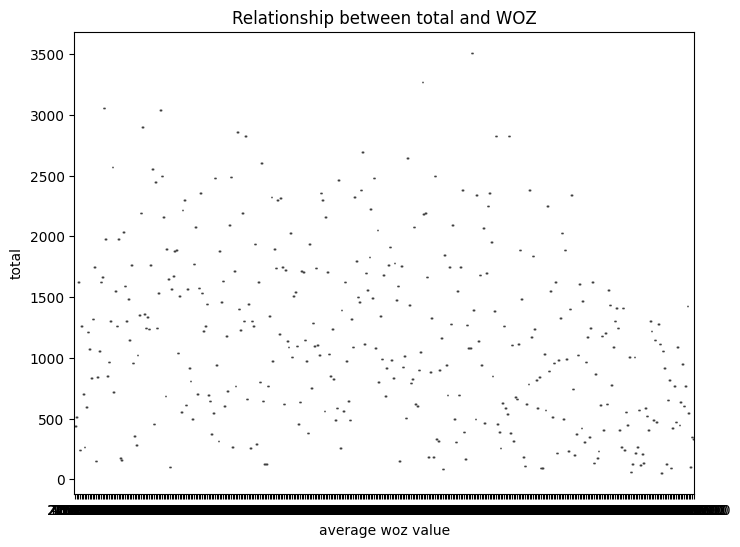

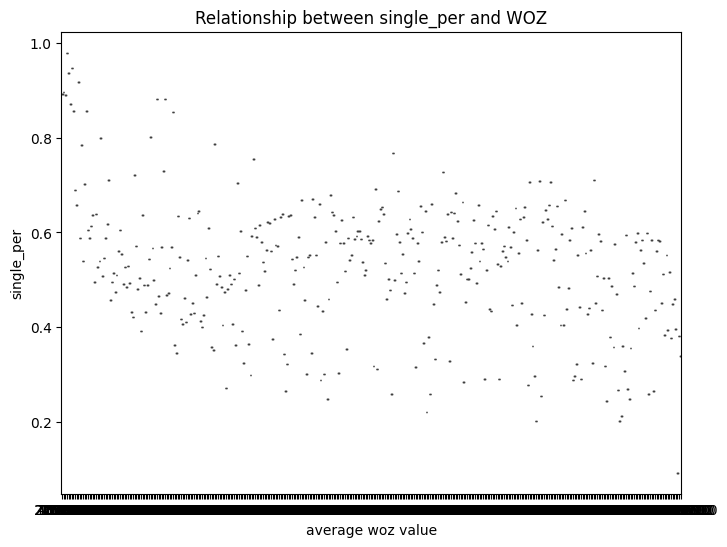

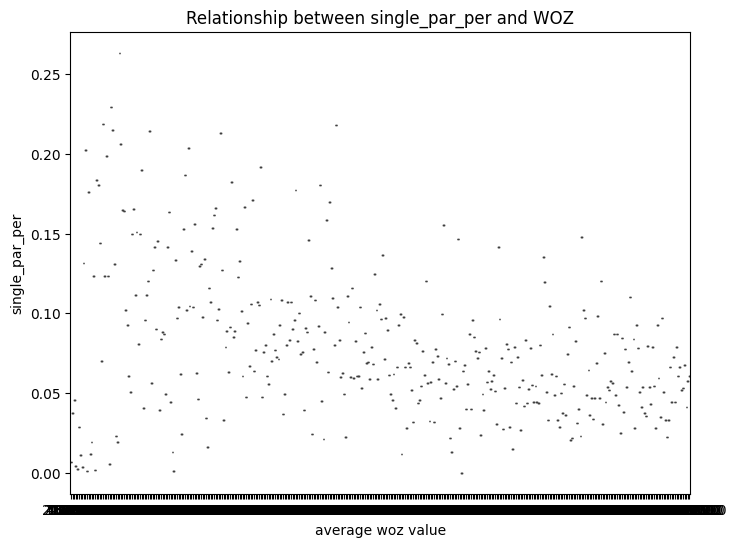

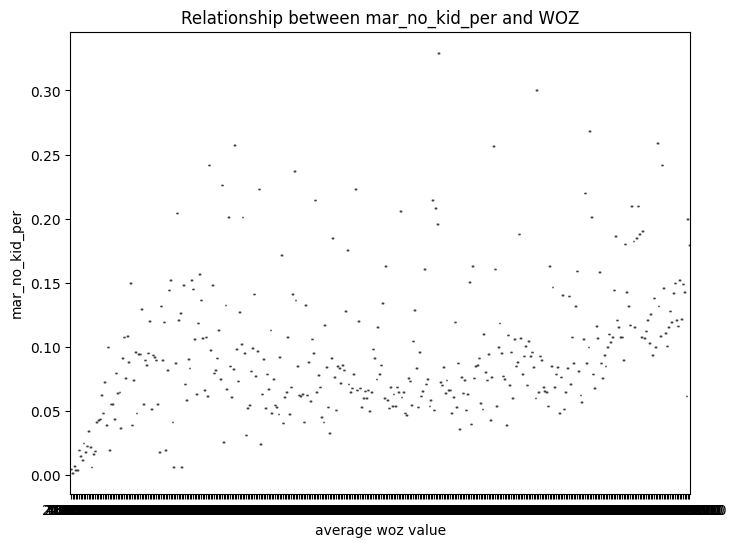

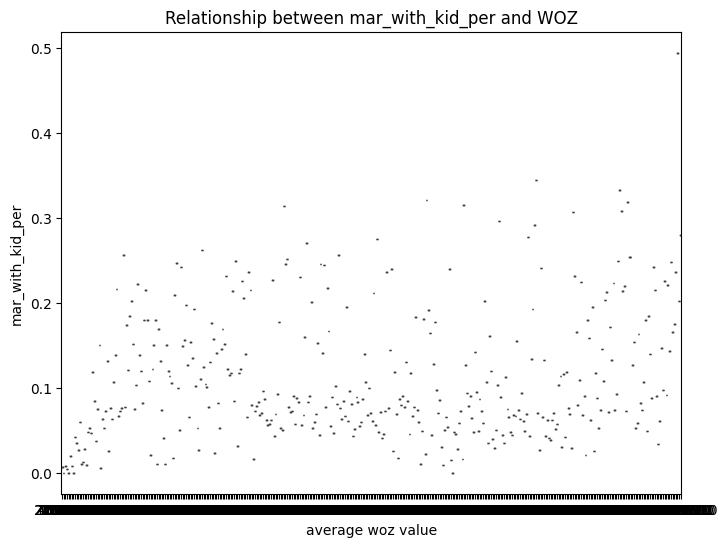

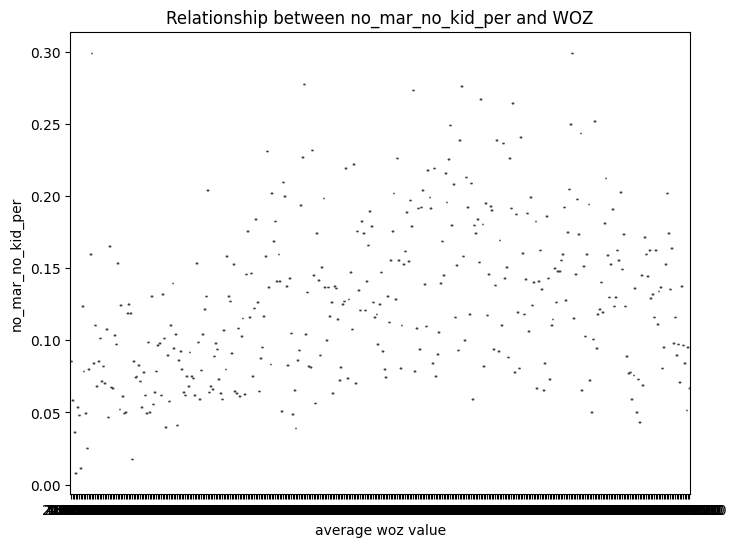

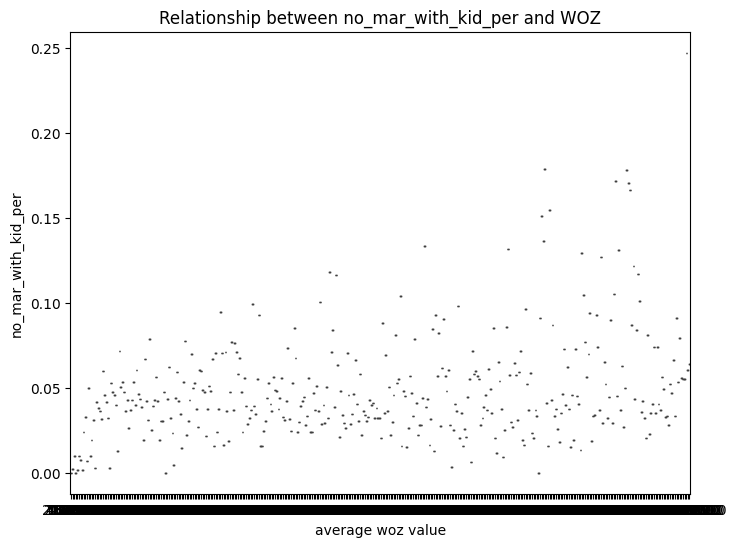

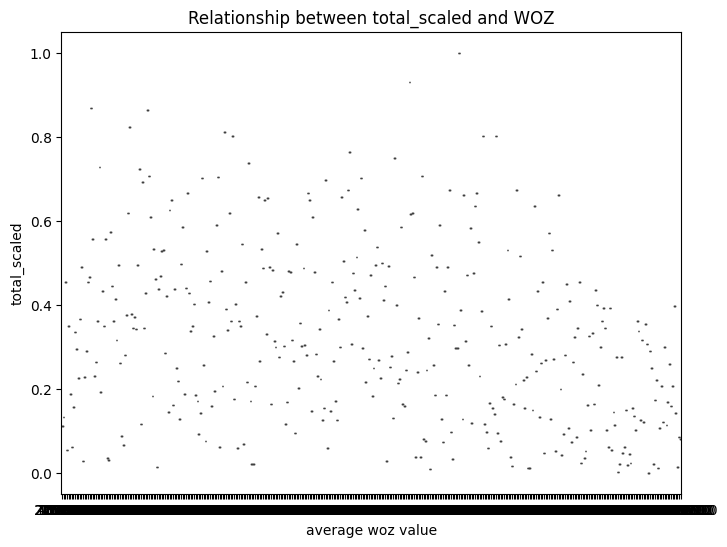

In [163]:
# # Visualize relationships between features and the target
y = df_no_area['average woz value']
X = df_no_area.drop('average woz value', axis=1)
for column in X.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y, y=X[column])
    plt.title(f'Relationship between {column} and WOZ')
    plt.show()

In [164]:
X

,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total,single_per,single_par_per,mar_no_kid_per,mar_with_kid_per,no_mar_no_kid_per,no_mar_with_kid_per,total_scaled
0,543,37,149,14,12,22,12,789,0.688,0.028,0.047,0.018,0.189,0.015,0.213
1,331,20,104,8,3,20,12,498,0.665,0.040,0.040,0.016,0.209,0.006,0.128
2,676,55,231,30,23,43,26,1084,0.624,0.040,0.051,0.028,0.213,0.021,0.298
3,130,16,59,5,8,11,5,234,0.556,0.047,0.068,0.021,0.252,0.034,0.052
4,348,24,73,19,9,14,6,493,0.706,0.028,0.049,0.039,0.148,0.018,0.127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,977,71,142,88,63,300,22,1663,0.587,0.180,0.043,0.053,0.085,0.038,0.465
382,421,41,70,72,51,186,10,851,0.495,0.219,0.048,0.085,0.082,0.060,0.230
383,380,362,91,325,107,125,14,1404,0.271,0.089,0.258,0.231,0.065,0.076,0.390
384,718,242,97,220,104,274,17,1672,0.429,0.164,0.145,0.132,0.058,0.062,0.468


In [169]:
# X = merged_df.drop('average woz value', axis=1)
# X = X.drop('area', axis=1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

y = df_with_percents['average woz value']
X = df_with_percents.drop('average woz value', axis=1)
X = X.drop('area', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate model
predictions_forest = forest_model.predict(X_test)
predictions_reg = reg_model.predict(X_test)
predictions_boost = xgb_model.predict(X_test)
mape_forest = mean_absolute_percentage_error(y_test, predictions_forest)
mape_boost = mean_absolute_percentage_error(y_test, predictions_boost)
mape_reg = mean_absolute_percentage_error(y_test, predictions_reg)
mae_forest = mean_absolute_error(y_test, predictions_forest)
mae_boost = mean_absolute_error(y_test, predictions_boost)
mae_reg = mean_absolute_error(y_test, predictions_reg)
print(f'Mean Absolute Error: {mae_forest}')
print(f'Mean Absolute Error: {mae_boost}')
print(f'Mean Absolute Error: {mae_reg}')
print(f'Mean Absolute Percentage Error: {mape_forest}')
print(f'Mean Absolute Percentage Error: {mape_boost}')
print(f'Mean Absolute Percentage Error: {mape_reg}')

Mean Absolute Error: 108558.79784482761
Mean Absolute Error: 109678.40557650862
Mean Absolute Error: 130176.72899850529
Mean Absolute Percentage Error: 0.2638826512388601
Mean Absolute Percentage Error: 0.2643221057111639
Mean Absolute Percentage Error: 0.41178227708080567


In [170]:
df_with_percents.columns # type: ignore

Index(['area', 'average woz value', 'single', 'married, no kids',
       'not married, no kids', 'married, with kids', 'not married, with kids',
       'single parent', 'other', 'total', 'single_per', 'single_par_per',
       'mar_no_kid_per', 'mar_with_kid_per', 'no_mar_no_kid_per',
       'no_mar_with_kid_per', 'total_scaled'],
      dtype='object')

In [171]:
list(enumerate(X.columns))

[(0, 'single'),
 (1, 'married, no kids'),
 (2, 'not married, no kids'),
 (3, 'married, with kids'),
 (4, 'not married, with kids'),
 (5, 'single parent'),
 (6, 'other'),
 (7, 'total'),
 (8, 'single_per'),
 (9, 'single_par_per'),
 (10, 'mar_no_kid_per'),
 (11, 'mar_with_kid_per'),
 (12, 'no_mar_no_kid_per'),
 (13, 'no_mar_with_kid_per'),
 (14, 'total_scaled')]

In [174]:

from tqdm.notebook import tqdm

df_mul_sum = df_with_percents.copy()
X = df_mul_sum.drop('area', axis=1)
X = X.drop('average woz value', axis=1)

for i in tqdm(range(8, 12)):
    for j in range(i + 1, 13):
        colname = f'{X.columns[i]}_{X.columns[j]}_product'
        # print(colname)
        df_mul_sum[colname] = X[X.columns[i]] * X[X.columns[j]]

# Create summation features
for i in tqdm(range(8, 13)):
    for j in range(i + 1, 13):
        colname = f'{X.columns[i]}_{X.columns[j]}_sum'
        df_mul_sum[colname] = X[X.columns[i]]+ X[X.columns[j]]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [175]:
df_mul_sum

,area,average woz value,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total,...,single_per_single_par_per_sum,single_per_mar_no_kid_per_sum,single_per_mar_with_kid_per_sum,single_per_no_mar_no_kid_per_sum,single_par_per_mar_no_kid_per_sum,single_par_per_mar_with_kid_per_sum,single_par_per_no_mar_no_kid_per_sum,mar_no_kid_per_mar_with_kid_per_sum,mar_no_kid_per_no_mar_no_kid_per_sum,mar_with_kid_per_no_mar_no_kid_per_sum
0,A00a Kop Zeedijk,432583.000,543,37,149,14,12,22,12,789,...,0.716,0.735,0.706,0.877,0.075,0.046,0.217,0.065,0.236,0.207
1,A00b Oude Kerk e.o.,475037.000,331,20,104,8,3,20,12,498,...,0.705,0.705,0.681,0.873,0.080,0.056,0.249,0.056,0.249,0.225
2,A00c Burgwallen Oost,469793.000,676,55,231,30,23,43,26,1084,...,0.663,0.674,0.651,0.837,0.090,0.067,0.253,0.078,0.264,0.241
3,A00d Nes e.o.,605863.000,130,16,59,5,8,11,5,234,...,0.603,0.624,0.577,0.808,0.115,0.068,0.299,0.090,0.321,0.274
4,A00e BG-terrein e.o.,556369.000,348,24,73,19,9,14,6,493,...,0.734,0.755,0.744,0.854,0.077,0.067,0.176,0.087,0.197,0.187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,T97a Gein Noordwest,211475.000,977,71,142,88,63,300,22,1663,...,0.768,0.630,0.640,0.673,0.223,0.233,0.266,0.096,0.128,0.138
382,T97b Gein Zuidwest,221090.000,421,41,70,72,51,186,10,851,...,0.713,0.543,0.579,0.577,0.267,0.303,0.301,0.133,0.130,0.167
383,T97c Gein Noordoost,332620.000,380,362,91,325,107,125,14,1404,...,0.360,0.528,0.502,0.335,0.347,0.321,0.154,0.489,0.323,0.296
384,T97d Gein Zuidoost,280695.000,718,242,97,220,104,274,17,1672,...,0.593,0.574,0.561,0.487,0.309,0.295,0.222,0.276,0.203,0.190


In [272]:
# X = merged_df.drop('average woz value', axis=1)
# X = X.drop('area', axis=1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

y = df_mul_sum['average woz value']
X = df_mul_sum.drop('average woz value', axis=1, errors='ignore')
X = X.drop('area', axis=1, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate model
predictions_forest = forest_model.predict(X_test)
predictions_reg = reg_model.predict(X_test)
predictions_boost = xgb_model.predict(X_test)
mape_forest = mean_absolute_percentage_error(y_test, predictions_forest)
mape_boost = mean_absolute_percentage_error(y_test, predictions_boost)
mape_reg = mean_absolute_percentage_error(y_test, predictions_reg)
mae_forest = mean_absolute_error(y_test, predictions_forest)
mae_boost = mean_absolute_error(y_test, predictions_boost)
mae_reg = mean_absolute_error(y_test, predictions_reg)
print(f'Mean Absolute Error forest: {mae_forest}')
print(f'Mean Absolute Error: {mae_boost}')
print(f'Mean Absolute Error: {mae_reg}')
print(f'Mean Absolute Percentage Error: {mape_forest}')
print(f'Mean Absolute Percentage Error: {mape_boost}')
print(f'Mean Absolute Percentage Error: {mape_reg}')

Mean Absolute Error forest: 99667.59724137929
Mean Absolute Error: 107986.16790140086
Mean Absolute Error: 118393.66465587656
Mean Absolute Percentage Error: 0.2566352752379165
Mean Absolute Percentage Error: 0.24760649610564114
Mean Absolute Percentage Error: 0.3258422205774206


In [287]:
X_train.columns[indices][22:]

Index(['mar_no_kid_per_mar_with_kid_per_sum',
       'single_par_per_mar_no_kid_per_product', 'not married, with kids',
       'other', 'not married, no kids', 'total',
       'single_par_per_mar_with_kid_per_sum', 'single_per_mar_no_kid_per_sum',
       'single_per', 'single_par_per_mar_with_kid_per_product',
       'single_par_per', 'single_per_no_mar_no_kid_per_sum', 'total_scaled'],
      dtype='object')

In [289]:
importances = forest_model.feature_importances_
indices = np.argsort(importances)[::-1]
columns_to_drop = X_train.columns[indices][:12]

df_mul_sum_crop = df_mul_sum.drop(columns_to_drop, axis=1)
df_mul_sum_crop

,area,average woz value,single,"married, no kids","married, with kids",single parent,other,mar_no_kid_per,mar_with_kid_per,no_mar_no_kid_per,...,single_par_per_no_mar_no_kid_per_product,mar_no_kid_per_mar_with_kid_per_product,mar_no_kid_per_no_mar_no_kid_per_product,mar_with_kid_per_no_mar_no_kid_per_product,single_per_single_par_per_sum,single_per_mar_with_kid_per_sum,single_par_per_mar_no_kid_per_sum,single_par_per_no_mar_no_kid_per_sum,mar_no_kid_per_no_mar_no_kid_per_sum,mar_with_kid_per_no_mar_no_kid_per_sum
0,A00a Kop Zeedijk,432583.000,543,37,14,22,12,0.047,0.018,0.189,...,0.005,0.001,0.009,0.003,0.716,0.706,0.075,0.217,0.236,0.207
1,A00b Oude Kerk e.o.,475037.000,331,20,8,20,12,0.040,0.016,0.209,...,0.008,0.001,0.008,0.003,0.705,0.681,0.080,0.249,0.249,0.225
2,A00c Burgwallen Oost,469793.000,676,55,30,43,26,0.051,0.028,0.213,...,0.008,0.001,0.011,0.006,0.663,0.651,0.090,0.253,0.264,0.241
3,A00d Nes e.o.,605863.000,130,16,5,11,5,0.068,0.021,0.252,...,0.012,0.001,0.017,0.005,0.603,0.577,0.115,0.299,0.321,0.274
4,A00e BG-terrein e.o.,556369.000,348,24,19,14,6,0.049,0.039,0.148,...,0.004,0.002,0.007,0.006,0.734,0.744,0.077,0.176,0.197,0.187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,T97a Gein Noordwest,211475.000,977,71,88,300,22,0.043,0.053,0.085,...,0.015,0.002,0.004,0.005,0.768,0.640,0.223,0.266,0.128,0.138
382,T97b Gein Zuidwest,221090.000,421,41,72,186,10,0.048,0.085,0.082,...,0.018,0.004,0.004,0.007,0.713,0.579,0.267,0.301,0.130,0.167
383,T97c Gein Noordoost,332620.000,380,362,325,125,14,0.258,0.231,0.065,...,0.006,0.060,0.017,0.015,0.360,0.502,0.347,0.154,0.323,0.296
384,T97d Gein Zuidoost,280695.000,718,242,220,274,17,0.145,0.132,0.058,...,0.010,0.019,0.008,0.008,0.593,0.561,0.309,0.222,0.203,0.190


In [302]:
# X = merged_df.drop('average woz value', axis=1)
# X = X.drop('area', axis=1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.svm import SVR
y = df_mul_sum_crop['average woz value']
X = df_mul_sum_crop.drop('average woz value', axis=1, errors='ignore')
X = X.drop('area', axis=1, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

svm_model = SVR()
svm_model.fit(X_train, y_train)

# Evaluate model
predictions_forest = forest_model.predict(X_test)
predictions_reg = reg_model.predict(X_test)
predictions_boost = xgb_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
mape_svm = mean_absolute_percentage_error(y_test, svm_pred)
mape_forest = mean_absolute_percentage_error(y_test, predictions_forest)
mape_boost = mean_absolute_percentage_error(y_test, predictions_boost)
mape_reg = mean_absolute_percentage_error(y_test, predictions_reg)
mae_forest = mean_absolute_error(y_test, predictions_forest)
mae_boost = mean_absolute_error(y_test, predictions_boost)
mae_reg = mean_absolute_error(y_test, predictions_reg)
# print(f'Mean Absolute Error forest: {mae_forest}')
# print(f'Mean Absolute Error: {mae_boost}')
# print(f'Mean Absolute Error: {mae_reg}')
print(f'Mean Absolute Error mape: {mape_svm}' )
print(f'Mean Absolute Percentage Error: {mape_forest}')
print(f'Mean Absolute Percentage Error: {mape_boost}')
print(f'Mean Absolute Percentage Error: {mape_reg}')

Mean Absolute Error mape: 0.5159522414606522
Mean Absolute Percentage Error: 0.26093541638165096
Mean Absolute Percentage Error: 0.2464235807700349
Mean Absolute Percentage Error: 0.31511366114723943


In [280]:
! pip install gensim
! pip install glove-python-binary

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement glove-python-binary (from versions: none)
ERROR: No matching distribution found for glove-python-binary


In [180]:
# from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Work with dfp, tokenize the area names
import nltk
import spacy

# Load the spacy model
nlp = spacy.load("en_core_web_sm")

dfp["area_tokens"] = dfp["area"].apply(lambda x: [token.text for token in nlp(x.lower())])
dfp["area_embedding"] = dfp["area_tokens"].apply(lambda x: nlp(" ".join(x)).vector)

# Download the required resources for tokenization
nltk.download('punkt')

# Tokenize the area names
dfp['tokenized_area'] = dfp['area'].apply(lambda x: word_tokenize(x.lower()))

# Print the tokenized area names
print(dfp['tokenized_area'])

4            [a00a, kop, zeedijk]
5      [a00b, oude, kerk, e.o, .]
6        [a00c, burgwallen, oost]
7             [a00d, nes, e.o, .]
8      [a00e, bg-terrein, e.o, .]
                  ...            
428       [t97a, gein, noordwest]
429        [t97b, gein, zuidwest]
430       [t97c, gein, noordoost]
431        [t97d, gein, zuidoost]
432        [t98a, dorp, driemond]
Name: tokenized_area, Length: 397, dtype: object


[nltk_data] Downloading package punkt to /Users/av/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# # from gensim.models import Word2Vec
# from nltk.tokenize import word_tokenize

# # Work with dfp, tokenize the area names
# import nltk
# import spacy

# # Load the spacy model
# import gensim.downloader as api

# # Download the pre-trained Word2Vec model
# model = api.load('word2vec-google-news-300')

# # Function to get the vector embedding for an area
# def get_embedding(area):
#     try:
#         embedding = model.wv[area]
#     except KeyError:
#         print('not found')
#         embedding = [0] * model.vector_size  # If area is not in the vocabulary, use zero vector
#     return embedding

# # Apply the function to create the embeddings column
# dfp['embeddings'] = dfp['area'].apply(get_embedding)

# # Tokenize the area names
# dfp['tokenized_area'] = dfp['area'].apply(lambda x: word_tokenize(x.lower()))

# # Print the tokenized area names
print(dfp['tokenized_area'])

In [ ]:
pip install sentence-transformers


In [182]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load the TinyBERT model
model_name = 'bert-base-uncased'
model = SentenceTransformer(model_name)
dfp['embeddings'] = dfp['area'].apply(lambda x: model.encode(x))


No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


In [183]:
dfp

,area,average woz value,area_tokens,area_embedding,tokenized_area,embeddings
4,A00a Kop Zeedijk,432583.000,"[a00a, kop, zeedijk]","[-0.68600804, -0.9978413, -0.63224536, 0.95578...","[a00a, kop, zeedijk]","[-0.031058038, -0.22711499, -0.052461363, -0.3..."
5,A00b Oude Kerk e.o.,475037.000,"[a00b, oude, kerk, e.o, .]","[-0.26522377, -1.0941982, 0.09830892, -0.13905...","[a00b, oude, kerk, e.o, .]","[-0.15884788, 0.079822466, 0.065997645, -0.244..."
6,A00c Burgwallen Oost,469793.000,"[a00c, burgwallen, oost]","[-0.656896, -1.1131207, 0.043604273, 0.0804316...","[a00c, burgwallen, oost]","[-0.14287876, -0.14300212, 0.29624793, -0.4577..."
7,A00d Nes e.o.,605863.000,"[a00d, nes, e.o, .]","[-0.5681063, -0.4853133, 0.1138305, -0.3723678...","[a00d, nes, e.o, .]","[-0.5844203, -0.38990027, 0.35301775, 0.264889..."
8,A00e BG-terrein e.o.,556369.000,"[a00e, bg, -, terrein, e.o, .]","[-0.050896198, -0.71786743, 0.77274203, 0.1542...","[a00e, bg-terrein, e.o, .]","[-0.3825517, -0.26926237, 0.25612813, 0.037668..."
...,...,...,...,...,...,...
428,T97a Gein Noordwest,211475.000,"[t97a, gein, noordwest]","[-0.59367615, -0.86792916, 0.43683657, -0.5293...","[t97a, gein, noordwest]","[-0.1821941, -0.14225318, -0.22723679, -0.4860..."
429,T97b Gein Zuidwest,221090.000,"[t97b, gein, zuidwest]","[-0.70546055, -0.88241535, 0.47562894, -0.3879...","[t97b, gein, zuidwest]","[-0.33048767, -0.18168485, -0.25841674, -0.497..."
430,T97c Gein Noordoost,332620.000,"[t97c, gein, noordoost]","[-0.81806785, -0.43933928, -0.15983707, -0.272...","[t97c, gein, noordoost]","[-0.13213238, -0.009441386, 0.083228216, -0.40..."
431,T97d Gein Zuidoost,280695.000,"[t97d, gein, zuidoost]","[-0.4297674, -0.4740236, 0.30786017, -0.130191...","[t97d, gein, zuidoost]","[-0.34278288, -0.031947758, -0.05225912, -0.40..."


In [44]:

# Calculate the embeddings for the 'area' column
embeddings = model.encode('Hello, how are you?')

# Print the embeddings
print(embeddings)
len(embeddings)


[-0.10193263 -0.3417251  -0.00241727 -0.3156259  -0.02676794 -0.3263678
  0.10514069  0.519996    0.02761877 -0.32932904 -0.15544294 -0.36661553
 -0.19807678  0.29616264 -0.1529372   0.37569445 -0.05264014  0.01539578
 -0.27512693  0.6586472   0.10135799 -0.72639585 -0.01201745  0.42417532
  0.3336139  -0.26639056 -0.41605225 -0.006147   -0.12374941 -0.6975255
  0.01728381  0.03412414 -0.6102067   0.01529215  0.30172908  0.08373795
 -0.02006762  0.09764099 -0.4919225   0.4199807  -0.7820608  -0.21670525
  0.08587538  0.25295085 -0.30259874 -0.93399894  0.13836154 -0.15772663
 -0.20713696 -0.30592304 -0.4586007   0.21019186 -0.30052418 -0.01702813
 -0.3517901   0.7173044  -0.37908363 -0.6268394  -0.547104    0.06751834
 -0.0519708  -0.25975943  0.12054001 -0.43955025  0.14084771  0.69637024
  0.05487945  0.15067548 -0.65215945  0.15400003 -0.70396364 -0.5687695
 -0.00828806 -0.06507915 -0.237157   -0.39737862 -0.51560706  0.13646504
 -0.51037    -0.19066334 -0.3161304   0.3953687   0.16

768

In [190]:
# Embeddings for the bert model
from sklearn.neighbors import NearestNeighbors

y = dfp['average woz value']
# X = dfp.drop('average woz value', axis=1)yy
X = dfp['embeddings']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a NearestNeighbors model
embeddings_train = np.stack(X_train.values)
embeddings_test = np.stack(X_test.values)

knn = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='cosine')
knn.fit(embeddings_train)

distances, indices = knn.kneighbors(embeddings_test)
predictions_knn = np.mean(y_train.values[[indices]].squeeze(), axis=1)

mae_knn = mean_absolute_error(y_test, predictions_knn)
mape_knn = mean_absolute_percentage_error(y_test, predictions_knn)

print(f'Mean Absolute Error: {mae_knn}')
print(f'Mean Absolute Percentage Error: {mape_knn}')


Mean Absolute Error: 170772.17916666667
Mean Absolute Percentage Error: 0.4844545016159192


In [191]:
# now the same with the embeddings from spacy
from sklearn.neighbors import NearestNeighbors

y = dfp['average woz value']
# X = dfm.drop('average woz value', axis=1)yy
X = dfp['area_embedding']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a NearestNeighbors model
embeddings_train = np.stack(X_train.values)
embeddings_test = np.stack(X_test.values)

knn = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='cosine')
knn.fit(embeddings_train)

distances, indices = knn.kneighbors(embeddings_test)

# predictions_knn = np.mean(y_train.values[[indices]], axis=0)
predictions_knn = np.mean(y_train.values[[indices]].squeeze(), axis=1)

mae_knn = mean_absolute_error(y_test, predictions_knn)
mape_knn = mean_absolute_percentage_error(y_test, predictions_knn)

print(f'Mean Absolute Error: {mae_knn}')
print(f'Mean Absolute Percentage Error: {mape_knn}')


Mean Absolute Error: 165985.9777777778
Mean Absolute Percentage Error: 0.4411235835194714


In order to use the predicted price with classifiers we have to calculate it for the whole dataset
So I will add

In [194]:
df_mul_sum.shape

(386, 37)

In [219]:
from sklearn.neighbors import KNeighborsRegressor

# Now we have to add the 'predicted by the knn' column to the X dataframe
# we are using 4 neighbors because we have 1 one will be skipped
knn_train = KNeighborsRegressor(n_neighbors=4, algorithm='auto', metric='cosine') 
knn_test = KNeighborsRegressor(n_neighbors=3, algorithm='auto', metric='cosine') 


# final_df = merged_df.merge(dfm[['area', 'embeddings']], on='area', how='left')
final_df = df_mul_sum.merge(dfp[['area', 'embeddings']], on='area', how='left')
y = final_df['average woz value']   
X = final_df.drop('average woz value', axis=1)
X_emb = final_df['embeddings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


embeddings_train = X_train['embeddings']
embeddings_test = X_test['embeddings']

knn_train.fit(np.stack(embeddings_train.values), np.stack(y_train.values))
knn_test.fit(np.stack(embeddings_train.values), np.stack(y_train.values))

distances_train, indices_train = knn_train.kneighbors(np.stack(embeddings_train.values))
distances_test, indices_test = knn_test.kneighbors(np.stack(embeddings_test.values))

# predictions_test = np.mean(y_test.values[[indices]].squeeze(), axis=1)
# predictions_test = np.mean(y_train.values[[indices]].squeeze(), axis=1)

distances_train

array([[1.1920929e-07, 8.8752270e-02, 9.7758710e-02, 1.0807651e-01],
       [0.0000000e+00, 8.6063266e-02, 9.4152451e-02, 9.7304463e-02],
       [0.0000000e+00, 1.1642945e-01, 1.2891078e-01, 1.2923169e-01],
       ...,
       [0.0000000e+00, 8.8702083e-02, 1.0779810e-01, 1.1010802e-01],
       [2.3841858e-07, 8.7297082e-02, 1.2445867e-01, 1.3168323e-01],
       [1.1920929e-07, 6.5057099e-02, 1.0965878e-01, 1.1220753e-01]],
      dtype=float32)

In [220]:
distances_test

array([[0.15787661, 0.24129903, 0.25962234],
       [0.04845017, 0.06120008, 0.09828091],
       [0.09985864, 0.11065644, 0.11561751],
       [0.05644238, 0.09509242, 0.09779513],
       [0.17960614, 0.18428594, 0.19536197],
       [0.03796387, 0.09631836, 0.09663689],
       [0.17651951, 0.18630028, 0.18663538],
       [0.1431371 , 0.16312474, 0.16573936],
       [0.08127856, 0.08734119, 0.08885992],
       [0.03591383, 0.08026302, 0.08795094],
       [0.05594754, 0.06297207, 0.06522942],
       [0.03382087, 0.0468725 , 0.13224316],
       [0.10020638, 0.1344974 , 0.13556862],
       [0.05707312, 0.09260792, 0.09983742],
       [0.10697532, 0.10749972, 0.11086702],
       [0.11400598, 0.1247918 , 0.1358347 ],
       [0.09402597, 0.10321349, 0.10684562],
       [0.04323435, 0.04324692, 0.06626105],
       [0.06472349, 0.09524161, 0.09579581],
       [0.07665455, 0.08642328, 0.08818436],
       [0.09366441, 0.11094624, 0.11283058],
       [0.04598337, 0.081747  , 0.08951545],
       [0.

In [221]:
y_train.values[[indices_train]]

array([[[ 683130.,  323671.,  590531.,  604774.],
        [1218480.,  461557., 1316577.,  524596.],
        [ 537299.,  864555.,  278228.,  906690.],
        ...,
        [ 756066.,  193321.,  404035.,  464576.],
        [ 511322.,  309861.,  514740.,  211475.],
        [ 453560., 1044805.,  646911.,  456686.]]])

In [222]:
y_train.values[[indices_train[:,1:]]]

array([[[ 323671.,  590531.,  604774.],
        [ 461557., 1316577.,  524596.],
        [ 864555.,  278228.,  906690.],
        [ 254949.,  369475.,  386026.],
        [ 441025.,  415352.,  813596.],
        [1316577.,  600101.,  461557.],
        [ 336757.,  407302.,  243389.],
        [ 431941.,  827588.,  524313.],
        [ 315933.,  441025.,  514740.],
        [ 332620.,  407302.,  444738.],
        [ 369475.,  254949.,  252782.],
        [  48486.,  253500.,  183713.],
        [ 237325.,  407302.,  220853.],
        [1046273.,  519732.,  183713.],
        [ 281042.,  323457.,  170679.],
        [ 417322.,  524596.,  562284.],
        [ 387312.,  281042.,  170679.],
        [ 383270.,  351711.,  243389.],
        [ 675279.,  413096.,  414022.],
        [ 345718.,  493029.,  604774.],
        [ 272142.,  365365.,  456259.],
        [ 404035.,  464576.,  455539.],
        [ 410143.,  524596.,  514740.],
        [ 334616.,  294382.,  675279.],
        [ 838287.,  537299.,  322259.],


In [223]:
indices_train[:, 1:]

array([[184, 263, 143],
       [167, 102, 157],
       [219,  48, 137],
       [226, 178,  10],
       [130, 120,  62],
       [102,  65, 167],
       [252, 160,  64],
       [151,  59, 230],
       [ 23, 130, 232],
       [235, 160, 239],
       [178, 226,  78],
       [185, 126, 139],
       [176, 160, 253],
       [141, 148, 139],
       [228,  16, 257],
       [ 68, 157, 109],
       [ 14, 228, 257],
       [147, 262,  64],
       [227,  87, 195],
       [135, 164, 143],
       [193,  25,  84],
       [ 77,  75,  43],
       [ 99, 157, 232],
       [  8, 251, 227],
       [134,   2, 149],
       [ 84,  30,  45],
       [170, 195, 200],
       [227, 246, 130],
       [  7,  76,  91],
       [112,   9,  21],
       [ 25, 263,  54],
       [ 41,  19, 107],
       [ 13, 141, 243],
       [207,  19, 269],
       [ 98, 190,  45],
       [171, 104,  47],
       [ 28,  20, 185],
       [260, 266, 171],
       [ 39, 100,  58],
       [ 38, 232, 197],
       [ 66, 221,  19],
       [ 31, 102

In [224]:
indices_train

array([[  0, 184, 263, 143],
       [  1, 167, 102, 157],
       [  2, 219,  48, 137],
       ...,
       [267,  90,  77,  75],
       [268, 170, 232,   9],
       [269,  50,  44,  22]])

In [238]:
predictions_knn_train = np.mean(y_train.values[[indices_train[:, 1:]]].squeeze(), axis=1)   
predictions_knn_test = np.mean(y_train.values[[indices_test]].squeeze(), axis=1) 

X_train['knn_predictions'] = predictions_knn_train
X_test['knn_predictions'] = predictions_knn_test

X_train = X_train.drop('embeddings', axis=1, errors='ignore')
X_test = X_test.drop('embeddings', axis=1, errors='ignore') 

X_train = X_train.drop('area', axis=1, errors='ignore')  
Xtest = X_test.drop('area', axis=1, errors='ignore')


In [241]:
# X_test.drop('area', axis=1, inplace=True)

X_train

,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total,single_per,single_par_per,...,single_per_mar_no_kid_per_sum,single_per_mar_with_kid_per_sum,single_per_no_mar_no_kid_per_sum,single_par_per_mar_no_kid_per_sum,single_par_per_mar_with_kid_per_sum,single_par_per_no_mar_no_kid_per_sum,mar_no_kid_per_mar_with_kid_per_sum,mar_no_kid_per_no_mar_no_kid_per_sum,mar_with_kid_per_no_mar_no_kid_per_sum,knn_predictions
24,256,40,77,33,12,17,9,444,0.577,0.038,...,0.667,0.651,0.750,0.128,0.113,0.212,0.164,0.264,0.248,506325.333
220,228,92,43,150,48,40,4,605,0.377,0.066,...,0.529,0.625,0.448,0.218,0.314,0.137,0.400,0.223,0.319,767576.667
337,205,51,77,110,86,35,5,569,0.360,0.062,...,0.450,0.554,0.496,0.151,0.255,0.197,0.283,0.225,0.329,683157.667
141,1385,256,121,388,83,317,20,2570,0.539,0.123,...,0.639,0.690,0.586,0.223,0.274,0.170,0.251,0.147,0.198,336816.667
238,1301,248,184,319,87,89,20,2248,0.579,0.040,...,0.689,0.721,0.661,0.150,0.181,0.121,0.252,0.192,0.224,556657.667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,346,57,87,38,27,57,4,616,0.562,0.093,...,0.654,0.623,0.703,0.185,0.154,0.234,0.154,0.234,0.203,433012.667
106,480,62,222,88,41,74,10,977,0.491,0.076,...,0.555,0.581,0.719,0.139,0.166,0.303,0.154,0.291,0.317,720459.667
270,214,118,79,311,168,111,7,1008,0.212,0.110,...,0.329,0.521,0.291,0.227,0.419,0.188,0.426,0.195,0.387,353977.333
348,322,121,98,329,146,86,6,1108,0.291,0.078,...,0.400,0.588,0.379,0.187,0.375,0.166,0.406,0.198,0.385,345358.667


In [240]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate model
predictions_forest = forest_model.predict(X_test)
predictions_reg = reg_model.predict(X_test)
predictions_boost = xgb_model.predict(X_test)
knn_mape_forest = mean_absolute_percentage_error(y_test, predictions_forest)
knn_mape_boost = mean_absolute_percentage_error(y_test, predictions_boost)
knn_mape_reg = mean_absolute_percentage_error(y_test, predictions_reg)
knn_mae_forest = mean_absolute_error(y_test, predictions_forest)
knn_mae_boost = mean_absolute_error(y_test, predictions_boost)
knn_mae_reg = mean_absolute_error(y_test, predictions_reg)
print(f'Mean Absolute Error : {knn_mae_forest}')
print(f'Mean Absolute Error: {knn_mae_boost}')
print(f'Mean Absolute Error: {knn_mae_reg}')
print(f'Mean Absolute Percentage Error: {knn_mape_forest}')
print(f'Mean Absolute Percentage Error: {knn_mape_boost}')
print(f'Mean Absolute Percentage Error: {knn_mape_reg}')

Mean Absolute Error: 100734.7968965517
Mean Absolute Error: 108770.29862607758
Mean Absolute Error: 117399.1414577527
Mean Absolute Percentage Error: 0.25705576283156545
Mean Absolute Percentage Error: 0.25812376550239624
Mean Absolute Percentage Error: 0.32631614748514143


In [260]:
X = merged_df.drop('average woz value', axis=1)
X = X.drop('area', axis=1)
y = merged_df['average woz value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train['knn_predictions'] = predictions_knn_train
X_test['knn_predictions'] = predictions_knn_test



In [261]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate model
predictions_forest = forest_model.predict(X_test)
predictions_reg = reg_model.predict(X_test)
predictions_boost = xgb_model.predict(X_test)
knn_mape_forest = mean_absolute_percentage_error(y_test, predictions_forest)
knn_mape_boost = mean_absolute_percentage_error(y_test, predictions_boost)
knn_mape_reg = mean_absolute_percentage_error(y_test, predictions_reg)
knn_mae_forest = mean_absolute_error(y_test, predictions_forest)
knn_mae_boost = mean_absolute_error(y_test, predictions_boost)
knn_mae_reg = mean_absolute_error(y_test, predictions_reg)
print(f'Mean Absolute Error: {knn_mae_forest}')
print(f'Mean Absolute Error: {knn_mae_boost}')
print(f'Mean Absolute Error: {knn_mae_reg}')
print(f'Mean Absolute Percentage Error: {knn_mape_forest}')
print(f'Mean Absolute Percentage Error: {knn_mape_boost}')
print(f'Mean Absolute Percentage Error: {knn_mape_reg}')

Mean Absolute Error: 123053.25629310343
Mean Absolute Error: 124747.31970635775
Mean Absolute Error: 146775.4644861378
Mean Absolute Percentage Error: 0.35312392620605676
Mean Absolute Percentage Error: 0.38255330361536743
Mean Absolute Percentage Error: 0.5008827517695681


In [262]:
X_train

,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total,knn_predictions
24,256,40,77,33,12,17,9,444,506325.333
220,228,92,43,150,48,40,4,605,767576.667
337,205,51,77,110,86,35,5,569,683157.667
141,1385,256,121,388,83,317,20,2570,336816.667
238,1301,248,184,319,87,89,20,2248,556657.667
...,...,...,...,...,...,...,...,...,...
71,346,57,87,38,27,57,4,616,433012.667
106,480,62,222,88,41,74,10,977,720459.667
270,214,118,79,311,168,111,7,1008,353977.333
348,322,121,98,329,146,86,6,1108,345358.667


In [265]:
y_train

24     683130.000
220   1218480.000
337    537299.000
141    222765.000
238    486923.000
          ...    
71     363886.000
106    378239.000
270    756066.000
348    511322.000
102    453560.000
Name: average woz value, Length: 270, dtype: float64

So there is no positive affect of embeddings of area

In [269]:
from sklearn.linear_model import Lasso



lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train.values)

# Select the important features
selected_features = X_train.columns[lasso.coef_ == 0]
print("Selected features:", selected_features)

Selected features: Index([], dtype='object')


In [15]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

linreg_model = LinearRegression()
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()
ada_model = AdaBoostRegressor()
knn_model = KNeighborsRegressor()
svr_model = SVR()
# nn_model = MLPRegressor(max_iter=1000)
xgb_model = xgb.XGBRegressor()

# List of models
models = {
    'Linear Regression': linreg_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ada_model,
    'K-Nearest Neighbors': knn_model,
    'Support Vector Regression': svr_model,
    # 'Neural Network': nn_model,
    'XGBoost': xgb_model
}

# Train models and calculate MAPE
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test,
                                           y_pred)
    print(f"{name} MAPE: {mape:.4f}")

Linear Regression MAPE: 0.5055
Random Forest MAPE: 0.3250
Gradient Boosting MAPE: 0.3175
AdaBoost MAPE: 0.4413
K-Nearest Neighbors MAPE: 0.4984
Support Vector Regression MAPE: 0.5160
XGBoost MAPE: 0.3089


In [16]:
import pickle

# Assuming your XGBoost model is stored in the variable 'model'
# model = XGBRegressor()

# Save the model to a file
filename = '../models/xgboost_model.pkl'
pickle.dump(models['XGBoost'], open(filename, 'wb'))

In [18]:
models['XGBoost'].save_model('../models/woz_xgb_model.json')

In [3]:
import xgboost as xgb
import pandas as pd

def load_model(model_path):
    model = xgb.XGBRegressor()
    model.load_model(model_path)
    return model

def predict(model, data):
    prediction = model.predict([list(data.values())])
    return prediction[0]

# def predict_list(model, data):
    # prediction = model.predict([list(data.values())])
    # return prediction[0]

In [4]:
mdl = load_model('../models/woz_xgb_model.json')


In [8]:
mdl.predict([[10, 5, 2, 8, 3, 1, 0, 29]])[0]

1219730.9

In [51]:
dat = X_test.iloc[0].values.tolist()

In [52]:
required_params = [
        'single', 'married_no_kids',
        'not_married_no_kids', 'married_with_kids', 'not_married_with_kids',
        'single_parent', 'other', 'total'
    ]

In [53]:
d = {'a': 1, 'b': 2, 'c': 3}

In [54]:
[d.values()]

[dict_values([1, 2, 3])]

In [55]:
d1 = dict(zip(required_params, dat))

In [56]:
mdl

XGBRegressor(base_score='4.6684184E5', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'int', 'int', 'int', 'int', 'int',
                            'int'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
list(d1.values())

[68, 8, 19, 35, 12, 6, 0, 148]

In [11]:
predict(mdl, {'single': 10, 'married_no_kids': 5, 'not_married_no_kids': 2, 'married_with_kids': 8, 'not_married_with_kids': 3, 'single_parent': 1, 'other': 0, 'total': 29})

1219730.9

In [59]:
print(xgb.__version__)

2.0.3


In [10]:
type(mdl)

xgboost.sklearn.XGBRegressor